# Filipino Homograph Restoration using LSTM Autoencoders

### Goal
Disambiguate Filipino homographs by restoring diacritics in undiacritized sentences.

### Models
1. **Vanilla LSTM Autoencoder** – simple encoder-decoder LSTM baseline.
2. **LSTM + Penalty Layer** – adds a penalty mask to prevent invalid character transformations (e.g., vowel-to-non‑vowel substitutions).
3. **LSTM + Residual + Penalty** – an attempt on enhancing the decoder by adding a residual from the mean of source embeddings into the initial hidden state of decoder LSTM, combined with the penalty layer.

### Metrics
- **Character-Level Accuracy (CLA)** – measures accuracy across all characters.
- **Vowel-Level Accuracy (VLA)** – evaluates accuracy specifically on vowels, to capture vowel restoration performance.
- **Homograph-Level Accuracy (HLA)** – focuses on entire words that contain diacritic vowels, assessing whether the model restores these words correctly in their full form.

In [ ]:
import os
import pickle
import unicodedata
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Sheen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Global constants
BATCH_SIZE = 32
LR = 0.001
LATENT_DIM = 64
EMBEDDING_DIM = 32 # Vocabulary size is 141
HIDDEN_DIM = 256 # Average line length is 189 characters
NUM_EPOCHS = 100
PATIENCE = 10
DATA_PATH = "data_splits.pkl"

# Load and Prepare Data

### Load Pre-split Data

In [ ]:
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

train_df = data["train"]
val_df = data["val"]
test_df = data["test"]

print(len(train_df), len(val_df), len(test_df))

3018 647 647


In [ ]:
print("Average line length:")
print(train_df["line"].str.len().mean())

Average line length:
189.22299536116634


### Initial Vocabulary

We are working under the assumption of a limited vocabulary. We need to consider that new sentences may introduce characters outside of vocabulary (OOV), so we are focusing only on the essentials, which are letters and diacritics, numbers, and basic punctuations.

In [ ]:
special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
letters = list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ')
diac_vowels = list('áéíóúàèìòùâêîôûÁÉÍÓÚÀÈÌÒÙÂÊÎÔÛ')
numbers = list('0123456789')
punctuation = list('.,;:!?\'"()-[]{}<>/@#$%&*~`|\\^_+= ')

chars = letters + diac_vowels + numbers + punctuation
vocab = special_tokens + chars

char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

PAD_IDX = char2idx['<PAD>']
SOS_IDX = char2idx['<SOS>']
EOS_IDX = char2idx['<EOS>']
UNK_IDX = char2idx['<UNK>']

In [ ]:
int_vocab_size = len(char2idx)
print(f"Initial vocabulary size: {int_vocab_size}")

Initial vocabulary size: 131


### Augmenting Vocabulary with Training Set

In [ ]:
train_text = ''.join(train_df['line'].tolist())
addtl_char = []
for c in set(train_text):
    if c not in char2idx:
        char2idx[c] = len(char2idx)
        idx2char[char2idx[c]] = c
        addtl_char.append(c)
        vocab.append(c)

In [ ]:
vocab_size = len(char2idx)
print(f"Final vocabulary size: {vocab_size}")

Final vocabulary size: 141


In [ ]:
if addtl_char:
    print("Additional characters found in training set:", addtl_char)

Additional characters found in training set: ['÷', '…', '”', '—', '“', '’', '̀', '˃', '‘', '–']


### Dataloader

In [ ]:
def remove_diacritics(text):
    decomposed = unicodedata.normalize('NFD', text)
    result = []
    i = 0
    while i < len(decomposed):
        c = decomposed[i]
        # Detect ñ
        if (c == 'n' or c == 'N') and i + 1 < len(decomposed) and decomposed[i+1] == '\u0303':
            result.append('ñ' if c == 'n' else 'Ñ')
            i += 2
            continue
        if not unicodedata.combining(c):
            result.append(c)
        i += 1
    return ''.join(result)

In [ ]:
text_sample = "Bilang halimbawa, napanaginipan ko ang Santo Niño minsan isang gabí."
remove_diacritics(text_sample)

'Bilang halimbawa, napanaginipan ko ang Santo Niño minsan isang gabi.'

In [ ]:
class DiacriticDataset(Dataset):
    def __init__(self, df):
        self.inputs = [remove_diacritics(s) for s in df['line'].tolist()]
        self.targets = df['line'].tolist()

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        input_seq = [char2idx.get(c, UNK_IDX) for c in self.inputs[idx]]
        target_seq = [SOS_IDX] + [char2idx.get(c, UNK_IDX) for c in self.targets[idx]] + [EOS_IDX]
        return torch.tensor(input_seq), torch.tensor(target_seq)

In [ ]:
data = {"line": ["Sánto Niño."]}
sample_df = pd.DataFrame(data)
sample_dataset = DiacriticDataset(sample_df)
sample_input_seq, sample_target_seq = sample_dataset[0]

print("Input (diacritics removed):", sample_dataset.inputs[0])
print("Input indices:", sample_input_seq.tolist())
print("Target (original):", sample_dataset.targets[0])
print("Target indices:", sample_target_seq.tolist())

Input (diacritics removed): Santo Niño.
Input indices: [50, 4, 17, 24, 19, 130, 44, 12, 18, 19, 98]
Target (original): Sánto Niño.
Target indices: [1, 50, 58, 17, 24, 19, 130, 44, 12, 18, 19, 98, 2]


In [ ]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    input_lengths = [len(seq) for seq in inputs]
    target_lengths = [len(seq) for seq in targets]

    inputs_padded = nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=PAD_IDX)
    targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=PAD_IDX)
    return inputs_padded, targets_padded, input_lengths, target_lengths

In a batch, all sequences are padded to match the length of the longest sequence, while the original lengths are tracked so the model knows which parts are real data versus padding.

In [ ]:
train_loader = DataLoader(DiacriticDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(DiacriticDataset(val_df), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(DiacriticDataset(test_df), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Evaluation Metrics

We have 3 evaluation metrics, all of which are based on accuracy.
### Character-Level Accuracy (CLA)
The proportion of all characters in the sentence that are predicted correctly.

$$
\text{CLA} = \frac{\text{# correctly predicted characters}}{\text{# total characters}}
$$

This measures raw reconstruction quality. It penalizes invalid transformations (e.g., a → p) that sometimes occur in unconstrained models.

### Vowel-Level Accuracy (VLA)
The proportion of all vowel characters in the sentence that are predicted correctly.

$$
\text{VLA} = \frac{\text{# vowels predicted correctly}}{\text{# total vowels}}
$$

Note that all Filipino diacritics (acute, grave, circumflex) appear only on vowels. Hence, non-vowels are irrelevant to diacritic restoration. So, this directly measures performance on characters where diacritic restoration is possible.

### Homograph-Level Accuracy (HLA)
The proportion of homographs in the dataset that are correctly restored to their intended diacritized form.

$$
\text{HLA} = \frac{\text{# correctly restored homographs}}{\text{# total homographs}}
$$

This directly measures the key task: disambiguation of homographs like punò/punô, sákit/sakít.

In [ ]:
vowel_chars_plain = set('aeiouAEIOU')
vowel_chars_diac  = set('áéíóúàèìòùâêîôûÁÉÍÓÚÀÈÌÒÙÂÊÎÔÛ')
vowel_chars_all   = vowel_chars_plain | vowel_chars_diac

vowel_idx = {char2idx[c] for c in vocab if c in vowel_chars_all}
SPECIAL_IDX = {PAD_IDX, SOS_IDX, EOS_IDX}

# Compute tensors for masks
vowel_tensor = torch.tensor(list(vowel_idx), device=device)
special_tensor = torch.tensor(list(SPECIAL_IDX), device=device)

def compute_batch_metrics(pred_batch, target_batch, idx2char, PAD_IDX):

    # Character-Level Accuracy (CLA)
    specials_mask = torch.ones_like(target_batch, dtype=torch.bool)
    for tok in (PAD_IDX, SOS_IDX, EOS_IDX):
        specials_mask &= (target_batch != tok)

    correct_chars = ((pred_batch == target_batch) & specials_mask).sum().item()
    total_chars = specials_mask.sum().item()
    CLA = correct_chars / total_chars if total_chars > 0 else 0.0

    # Vowel-Level Accuracy (VLA)
    target_flat = target_batch.flatten()
    pred_flat   = pred_batch.flatten()

    vowel_mask = torch.isin(target_flat, vowel_tensor)
    specials_flat = torch.isin(target_flat, special_tensor)
    vowel_mask = vowel_mask & (~specials_flat)

    total_vowels = int(vowel_mask.sum().item())
    correct_vowels = int((pred_flat[vowel_mask] == target_flat[vowel_mask]).sum().item())
    VLA = correct_vowels / total_vowels if total_vowels > 0 else 0.0

    # Homograph-Level Accuracy (HLA)
    H_correct, H_total = 0, 0
    pred_np   = pred_batch.cpu().numpy()
    target_np = target_batch.cpu().numpy()

    for b in range(pred_batch.shape[0]):
        pred_seq   = [idx for idx in pred_np[b]   if idx not in SPECIAL_IDX]
        target_seq = [idx for idx in target_np[b] if idx not in SPECIAL_IDX]
        pred_str   = ''.join(idx2char[idx] for idx in pred_seq)
        targ_str   = ''.join(idx2char[idx] for idx in target_seq)

        pred_words = pred_str.split()
        targ_words = targ_str.split()

        for pw, tw in zip(pred_words, targ_words):
            if any(c in vowel_chars_diac for c in tw):
                H_total += 1
                if pw == tw:
                    H_correct += 1

    HLA = H_correct / H_total if H_total > 0 else 0.0
    return {"CLA": CLA, "VLA": VLA, "HLA": HLA}

# Model Definition

### Vanilla LSTM Autoencoder

In [ ]:
class VanillaEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_latent = nn.Linear(hidden_dim, latent_dim)
        self.pad_idx = pad_idx

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        latent = self.fc_latent(h.squeeze(0))
        return latent


class VanillaDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.pad_idx = pad_idx

    def forward(self, trg, latent, trg_lengths):

        h0 = torch.tanh(self.latent_to_hidden(latent)).unsqueeze(0)
        c0 = torch.zeros_like(h0)

        embedded = self.embedding(trg)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, trg_lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed, (h0, c0))
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, padding_value=self.pad_idx)

        logits = self.fc(output)
        return logits


class VanillaSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_lengths, trg, trg_lengths):
        latent = self.encoder(src, src_lengths)
        output = self.decoder(trg, latent, trg_lengths)
        return output

In [ ]:
encoder_vanilla = VanillaEncoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
decoder_vanilla = VanillaDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
model1 = VanillaSeq2Seq(encoder_vanilla, decoder_vanilla).to(device)

### LSTM Autoencoder + Penalty Layer

In [ ]:
class PenaltyLayer(nn.Module):
    def __init__(self, vocab, vocab_size, device, scale=1.2):
        super().__init__()
        self.vocab = vocab
        self.vocab_size = vocab_size
        self.scale = scale

        vowels_plain = set('aeiouAEIOU')
        vowels_diac  = set('áéíóúàèìòùâêîôûÁÉÍÓÚÀÈÌÒÙÂÊÎÔÛ')

        # Map diacritized vowels to undiacritized bases
        base_map = {}
        for c in vowels_diac:
            nfd = unicodedata.normalize('NFD', c)
            base_map[c] = nfd[0]

        mask = torch.ones((vocab_size, vocab_size), device=device)
        for i, c_in in enumerate(vocab):
            for j, c_out in enumerate(vocab):
                if c_in == c_out:
                    mask[i, j] = 0.0
                elif c_in in vowels_plain and (c_out in vowels_plain or c_out in vowels_diac):
                    mask[i, j] = 0.0
                elif c_in in vowels_diac:
                    base = base_map[c_in]
                    if c_out == base or c_out in vowels_plain or c_out in vowels_diac:
                        mask[i, j] = 0.0
        self.register_buffer('mask', mask)

    def forward(self, logits, source_inputs):
        max_logits = logits.max(dim=-1, keepdim=True)[0]
        min_logits = logits.min(dim=-1, keepdim=True)[0]
        range_logits = max_logits - min_logits
        penalties = self.mask[source_inputs] * (self.scale * range_logits)
        return logits - penalties

In [ ]:
class PenaltySeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab, vocab_size, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.penalty = PenaltyLayer(vocab, vocab_size, device)

    def forward(self, src, src_lengths, trg_in, trg_lengths):
        latent = self.encoder(src, src_lengths)
        logits = self.decoder(trg_in, latent, trg_lengths)

        B, T_in = logits.size(0), logits.size(1)
        eos_col = torch.full((B, 1), EOS_IDX, dtype=src.dtype, device=src.device)
        src_aligned_full = torch.cat([src, eos_col], dim=1)

        if src_aligned_full.size(1) < T_in:
            pad = torch.full((B, T_in - src_aligned_full.size(1)), PAD_IDX, dtype=src.dtype, device=src.device)
            src_aligned = torch.cat([src_aligned_full, pad], dim=1)
        else:
            src_aligned = src_aligned_full[:, :T_in]

        return self.penalty(logits, src_aligned)

In [ ]:
encoder_penalty = VanillaEncoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
decoder_penalty = VanillaDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
model2 = PenaltySeq2Seq(encoder_penalty, decoder_penalty, vocab, vocab_size, device).to(device)

### LSTM Autoencoder + Residual + Penalty Layer

In [ ]:
class ResidualDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.src_proj = nn.Linear(embedding_dim, hidden_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.pad_idx = pad_idx

    def forward(self, trg, latent, trg_lengths, src_embedded):
        h_latent = torch.tanh(self.latent_to_hidden(latent))
        src_residual = self.src_proj(src_embedded.mean(dim=1))
        h0 = (h_latent + src_residual).unsqueeze(0)
        c0 = torch.zeros_like(h0)

        embedded = self.embedding(trg)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, trg_lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed, (h0, c0))
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, padding_value=self.pad_idx)

        logits = self.fc(output)
        return logits


class ResidualPenaltySeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab, vocab_size, device, scale=1.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.penalty = PenaltyLayer(vocab, vocab_size, device, scale)
        self.src_embedding = encoder.embedding

    def forward(self, src, src_lengths, trg_in, trg_lengths):
        latent = self.encoder(src, src_lengths)
        src_embedded = self.src_embedding(src)
        logits = self.decoder(trg_in, latent, trg_lengths, src_embedded)

        B, T_in = logits.size(0), logits.size(1)
        eos_col = torch.full((B, 1), EOS_IDX, dtype=src.dtype, device=src.device)
        src_aligned_full = torch.cat([src, eos_col], dim=1)

        if src_aligned_full.size(1) < T_in:
            pad = torch.full((B, T_in - src_aligned_full.size(1)),
                             PAD_IDX, dtype=src.dtype, device=src.device)
            src_aligned = torch.cat([src_aligned_full, pad], dim=1)
        else:
            src_aligned = src_aligned_full[:, :T_in]

        return self.penalty(logits, src_aligned)

In [ ]:
encoder_residual = VanillaEncoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
decoder_residual = ResidualDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, LATENT_DIM, PAD_IDX)
model3 = ResidualPenaltySeq2Seq(encoder_residual, decoder_residual, vocab, vocab_size, device).to(device)

All three architectures in this work are implemented as custom `nn.Module` classes, satisfying the requirement that the research contribution must be expressed through our own PyTorch modules rather than simply wrapping existing ones.

1. **Vanilla LSTM Autoencoder**  
   - Implemented through `VanillaEncoder`, `VanillaDecoder`, and `VanillaSeq2Seq` classes.  
   - While these use standard PyTorch layers (`nn.Embedding`, `nn.LSTM`, `nn.Linear`), the encoder–decoder structure and latent projection are composed manually.  
   - This ensures the baseline is a fully custom module that can be extended with new ideas.

2. **LSTM + Penalty Layer**  
   - Introduces a novel `PenaltyLayer` class that extends `nn.Module`.  
   - The penalty mask logic is entirely custom: it restricts invalid character transformations (e.g., vowel → non‑vowel) by subtracting scaled penalties from logits.  
   - This mechanism is not available in PyTorch by default and represents a direct implementation of the researched idea.

3. **LSTM + Residual + Penalty**  
   - Defines a custom `ResidualDecoder` class that augments the decoder with a residual connection from mean‑pooled source embeddings into the initial hidden state.  
   - Combined with the `PenaltyLayer`, this creates the `ResidualPenaltySeq2Seq` model.  
   - The residual mechanism is implemented manually, demonstrating how existing PyTorch primitives can be extended to realize new architectural concepts.

In all cases, the models are not simple wrappers of existing PyTorch modules. They extend standard components with original logic, fulfilling the requirement for custom implementations.

# Training

### Loss Function & Optimizers

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LR)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=LR)

### Training Utilities

In [ ]:
# Helper Functions
def greedy_decode(model, src, src_lengths, max_len, device, SOS_IDX, EOS_IDX, PAD_IDX):
    model.eval()
    batch_size = src.size(0)

    if not torch.is_tensor(src_lengths):
        src_lengths = torch.tensor(src_lengths, dtype=torch.long)
    src_lengths = src_lengths.cpu()

    with torch.no_grad():
        latent = model.encoder(src, src_lengths)
        h = torch.tanh(model.decoder.latent_to_hidden(latent)).unsqueeze(0)  # (1, B, H)
        c = torch.zeros_like(h)

        eos_col = torch.full((batch_size, 1), EOS_IDX, dtype=src.dtype, device=src.device)
        src_aligned_full = torch.cat([src, eos_col], dim=1)

        prev_token = torch.full((batch_size, 1), SOS_IDX, dtype=torch.long, device=device)
        outputs = []

        for t in range(max_len):
            embedded = model.decoder.embedding(prev_token)
            out, (h, c) = model.decoder.lstm(embedded, (h, c))
            logits = model.decoder.fc(out)

            src_tok = src_aligned_full[:, t:t+1] if t < src_aligned_full.size(1) \
                      else torch.full((batch_size, 1), EOS_IDX, dtype=src.dtype, device=src.device)

            if hasattr(model, "penalty"):
                logits = model.penalty(logits, src_tok)

            pred = logits.argmax(dim=-1)
            outputs.append(pred)
            prev_token = pred

            if (pred == EOS_IDX).all():
                break

        predictions = torch.cat(outputs, dim=1)
    return predictions

def train_one_epoch(model, loader, optimizer, criterion, vocab_size, device, idx2char, PAD_IDX):
    model.train()
    total_loss = 0.0
    batch_metrics = []

    for inputs, targets, input_lengths, target_lengths in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        src_lengths = torch.tensor(input_lengths, dtype=torch.long).cpu()
        trg_lengths = torch.tensor(target_lengths, dtype=torch.long).cpu() - 1

        outputs = model(inputs, src_lengths, targets[:, :-1], trg_lengths)
        targets_out = targets[:, 1:]

        loss = criterion(outputs.reshape(-1, vocab_size), targets_out.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = outputs.argmax(dim=-1)
        metrics = compute_batch_metrics(preds, targets_out, idx2char, PAD_IDX)  # dict
        batch_metrics.append(metrics)

    avg_loss = total_loss / max(len(loader), 1)
    avg_metrics = {k: float(np.mean([m[k] for m in batch_metrics])) for k in batch_metrics[0]} \
                  if batch_metrics else {'CLA': 0.0, 'VLA': 0.0, 'HLA': 0.0}
    return avg_loss, avg_metrics

def validate(model, loader, criterion, vocab_size, device, idx2char, PAD_IDX, SOS_IDX, EOS_IDX):
    model.eval()
    val_loss = 0.0
    batch_metrics = []

    with torch.no_grad():
        for inputs, targets, input_lengths, target_lengths in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            src_lengths = torch.tensor(input_lengths, dtype=torch.long).cpu()
            trg_lengths = torch.tensor(target_lengths, dtype=torch.long).cpu() - 1

            outputs = model(inputs, src_lengths, targets[:, :-1], trg_lengths)
            targets_out = targets[:, 1:]

            loss = criterion(outputs.reshape(-1, vocab_size), targets_out.reshape(-1))
            val_loss += loss.item()

            preds = greedy_decode(model, inputs, input_lengths, max_len=targets.size(1) - 1,
                                  device=device, SOS_IDX=SOS_IDX, EOS_IDX=EOS_IDX, PAD_IDX=PAD_IDX)

            if preds.size(1) < targets_out.size(1):
                pad = torch.full((preds.size(0), targets_out.size(1) - preds.size(1)),
                                 PAD_IDX, dtype=preds.dtype, device=preds.device)
                preds = torch.cat([preds, pad], dim=1)
            else:
                preds = preds[:, :targets_out.size(1)]

            metrics = compute_batch_metrics(preds, targets_out, idx2char, PAD_IDX)  # dict
            batch_metrics.append(metrics)

    avg_loss = val_loss / max(len(loader), 1)
    avg_metrics = {k: float(np.mean([m[k] for m in batch_metrics])) for k in batch_metrics[0]} \
                  if batch_metrics else {'CLA': 0.0, 'VLA': 0.0, 'HLA': 0.0}
    return avg_loss, avg_metrics

### Training & Validation

In [ ]:
models = {'Vanilla': (model1, optimizer1),
          'Penalty': (model2, optimizer2),
          'Residual-Penalty': (model3, optimizer3)}

NUM_EPOCHS = NUM_EPOCHS

In [ ]:
logs_all = {}
best_models = {}

In [ ]:
def train_model(name, model, optimizer, train_loader, val_loader, criterion, vocab_size, device, num_epochs, patience, idx2char, PAD_IDX, SOS_IDX, EOS_IDX):
    print(f"Training {name} model")
    model = model.to(device)

    logs = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model_path = f"best_{name}.pt"

    for epoch in range(num_epochs):
        train_loss, train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, vocab_size, device, idx2char, PAD_IDX)
        val_loss, val_metrics = validate(model, val_loader, criterion, vocab_size, device, idx2char, PAD_IDX, SOS_IDX, EOS_IDX)

        logs.append({
            'train_loss': train_loss, 'val_loss': val_loss,
            'train_CLA': train_metrics['CLA'], 'train_VLA': train_metrics['VLA'], 'train_HLA': train_metrics['HLA'],
            'val_CLA': val_metrics['CLA'], 'val_VLA': val_metrics['VLA'], 'val_HLA': val_metrics['HLA']
        })

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"Val CLA={val_metrics['CLA']:.3f} | Val VLA={val_metrics['VLA']:.3f} | Val HLA={val_metrics['HLA']:.3f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}.")
                break

    return logs, model_path

In [ ]:
start_time = time.time()
##############################
logs_vanilla, path_vanilla = train_model("Vanilla", model1, optimizer1, train_loader, val_loader,
                                         criterion, vocab_size, device, NUM_EPOCHS, PATIENCE,
                                         idx2char, PAD_IDX, SOS_IDX, EOS_IDX)
best_models["Vanilla"] = path_vanilla
logs_all["Vanilla"] = logs_vanilla
##############################
end_time = time.time()
run_time = end_time - start_time
print(f"Training runtime (Vanilla): {run_time:.4f} seconds")

Training Vanilla model
Epoch 1/100 | Train Loss=2.8679 | Val Loss=2.3679 | Val CLA=0.106 | Val VLA=0.103 | Val HLA=0.000
Epoch 2/100 | Train Loss=2.1937 | Val Loss=2.0939 | Val CLA=0.115 | Val VLA=0.160 | Val HLA=0.000
Epoch 3/100 | Train Loss=2.0175 | Val Loss=1.9782 | Val CLA=0.114 | Val VLA=0.179 | Val HLA=0.000
Epoch 4/100 | Train Loss=1.9266 | Val Loss=1.9052 | Val CLA=0.115 | Val VLA=0.190 | Val HLA=0.000
Epoch 5/100 | Train Loss=1.8581 | Val Loss=1.8474 | Val CLA=0.115 | Val VLA=0.190 | Val HLA=0.000
Epoch 6/100 | Train Loss=1.8061 | Val Loss=1.7985 | Val CLA=0.118 | Val VLA=0.184 | Val HLA=0.000
Epoch 7/100 | Train Loss=1.7598 | Val Loss=1.7575 | Val CLA=0.116 | Val VLA=0.185 | Val HLA=0.000
Epoch 8/100 | Train Loss=1.7213 | Val Loss=1.7220 | Val CLA=0.113 | Val VLA=0.185 | Val HLA=0.000
Epoch 9/100 | Train Loss=1.6862 | Val Loss=1.6934 | Val CLA=0.113 | Val VLA=0.185 | Val HLA=0.000
Epoch 10/100 | Train Loss=1.6535 | Val Loss=1.6631 | Val CLA=0.111 | Val VLA=0.154 | Val HLA=0.

In [ ]:
start_time = time.time()
##############################
logs_penalty, path_penalty = train_model("Penalty", model2, optimizer2, train_loader, val_loader,
                                         criterion, vocab_size, device, NUM_EPOCHS, PATIENCE,
                                         idx2char, PAD_IDX, SOS_IDX, EOS_IDX)
best_models["Penalty"] = path_penalty
logs_all["Penalty"] = logs_penalty
##############################
end_time = time.time()
run_time = end_time - start_time
print(f"Training runtime (Penalty): {run_time:.4f} seconds")

Training Penalty model
Epoch 1/100 | Train Loss=0.8318 | Val Loss=0.4922 | Val CLA=0.842 | Val VLA=0.532 | Val HLA=0.000
Epoch 2/100 | Train Loss=0.4823 | Val Loss=0.4661 | Val CLA=0.843 | Val VLA=0.535 | Val HLA=0.000
Epoch 3/100 | Train Loss=0.4578 | Val Loss=0.4450 | Val CLA=0.843 | Val VLA=0.535 | Val HLA=0.000
Epoch 4/100 | Train Loss=0.4395 | Val Loss=0.4274 | Val CLA=0.845 | Val VLA=0.542 | Val HLA=0.000
Epoch 5/100 | Train Loss=0.4278 | Val Loss=0.4168 | Val CLA=0.846 | Val VLA=0.545 | Val HLA=0.000
Epoch 6/100 | Train Loss=0.4153 | Val Loss=0.4107 | Val CLA=0.851 | Val VLA=0.559 | Val HLA=0.000
Epoch 7/100 | Train Loss=0.4075 | Val Loss=0.4022 | Val CLA=0.852 | Val VLA=0.560 | Val HLA=0.000
Epoch 8/100 | Train Loss=0.3986 | Val Loss=0.3919 | Val CLA=0.856 | Val VLA=0.574 | Val HLA=0.000
Epoch 9/100 | Train Loss=0.3911 | Val Loss=0.3847 | Val CLA=0.858 | Val VLA=0.580 | Val HLA=0.020
Epoch 10/100 | Train Loss=0.3836 | Val Loss=0.3774 | Val CLA=0.858 | Val VLA=0.579 | Val HLA=0.

In [ ]:
start_time = time.time()
##############################
logs_residual_penalty, path_residual_penalty = train_model("Residual-Penalty", model3, optimizer3, train_loader, val_loader,
                                                           criterion, vocab_size, device, NUM_EPOCHS, PATIENCE,
                                                           idx2char, PAD_IDX, SOS_IDX, EOS_IDX)
best_models["Residual-Penalty"] = path_residual_penalty
logs_all["Residual-Penalty"] = logs_residual_penalty
##############################
end_time = time.time()
run_time = end_time - start_time
print(f"Training runtime (Residual-Penalty): {run_time:.4f} seconds")

Training Residual-Penalty model
Epoch 1/100 | Train Loss=0.8165 | Val Loss=0.4908 | Val CLA=0.842 | Val VLA=0.532 | Val HLA=0.000
Epoch 2/100 | Train Loss=0.4801 | Val Loss=0.4638 | Val CLA=0.842 | Val VLA=0.532 | Val HLA=0.000
Epoch 3/100 | Train Loss=0.4574 | Val Loss=0.4477 | Val CLA=0.843 | Val VLA=0.535 | Val HLA=0.000
Epoch 4/100 | Train Loss=0.4405 | Val Loss=0.4280 | Val CLA=0.847 | Val VLA=0.546 | Val HLA=0.000
Epoch 5/100 | Train Loss=0.4250 | Val Loss=0.4148 | Val CLA=0.848 | Val VLA=0.550 | Val HLA=0.000
Epoch 6/100 | Train Loss=0.4126 | Val Loss=0.4042 | Val CLA=0.851 | Val VLA=0.559 | Val HLA=0.000
Epoch 7/100 | Train Loss=0.4030 | Val Loss=0.3972 | Val CLA=0.853 | Val VLA=0.564 | Val HLA=0.039
Epoch 8/100 | Train Loss=0.3942 | Val Loss=0.3857 | Val CLA=0.857 | Val VLA=0.575 | Val HLA=0.061
Epoch 9/100 | Train Loss=0.3840 | Val Loss=0.3773 | Val CLA=0.859 | Val VLA=0.583 | Val HLA=0.092
Epoch 10/100 | Train Loss=0.3754 | Val Loss=0.3679 | Val CLA=0.860 | Val VLA=0.585 | V

# Results: Supervised Evaluation

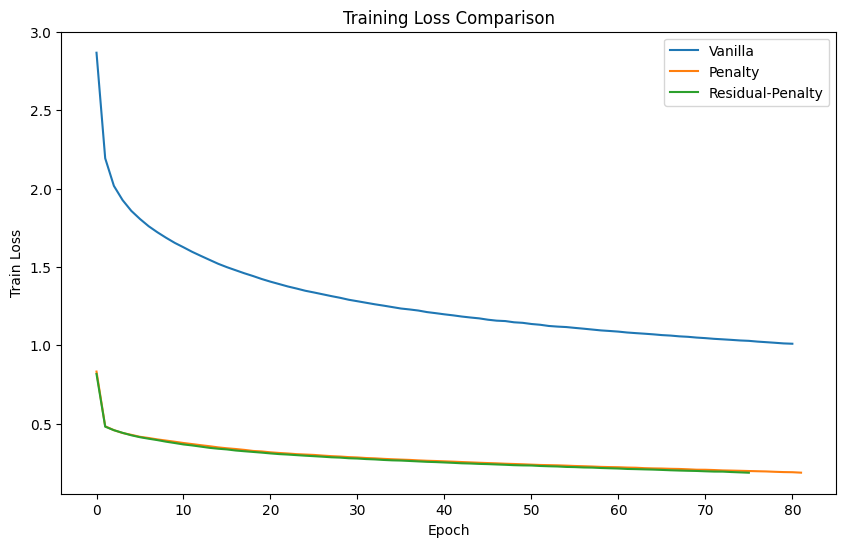

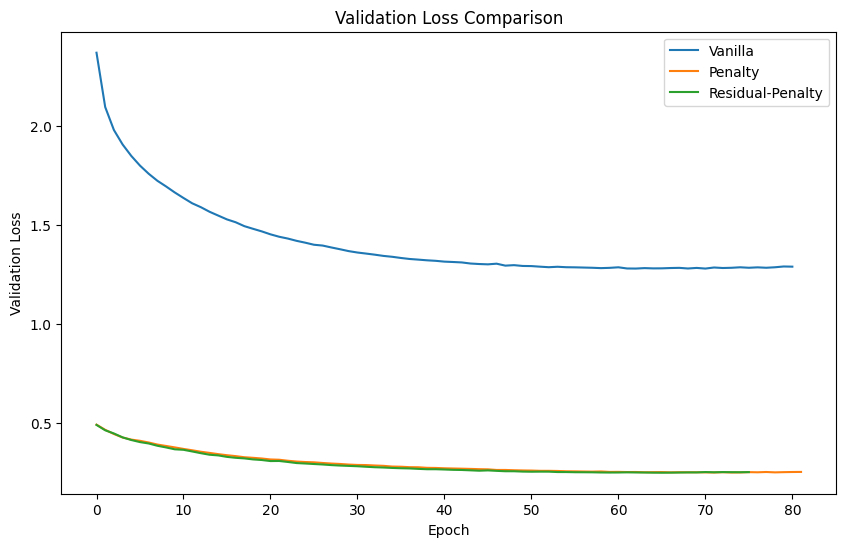

In [ ]:
loss_logs = {
    "Vanilla": logs_vanilla,
    "Penalty": logs_penalty,
    "Residual-Penalty": logs_residual_penalty
}

plt.figure(figsize=(10,6))
for name, logs in loss_logs.items():
    plt.plot([l['train_loss'] for l in logs], label=f"{name}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for name, logs in loss_logs.items():
    plt.plot([l['val_loss'] for l in logs], label=f"{name}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()

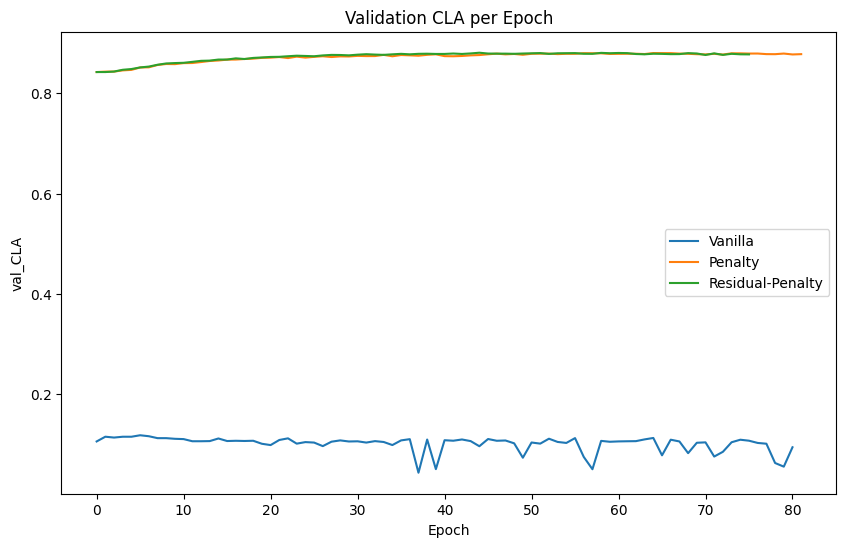

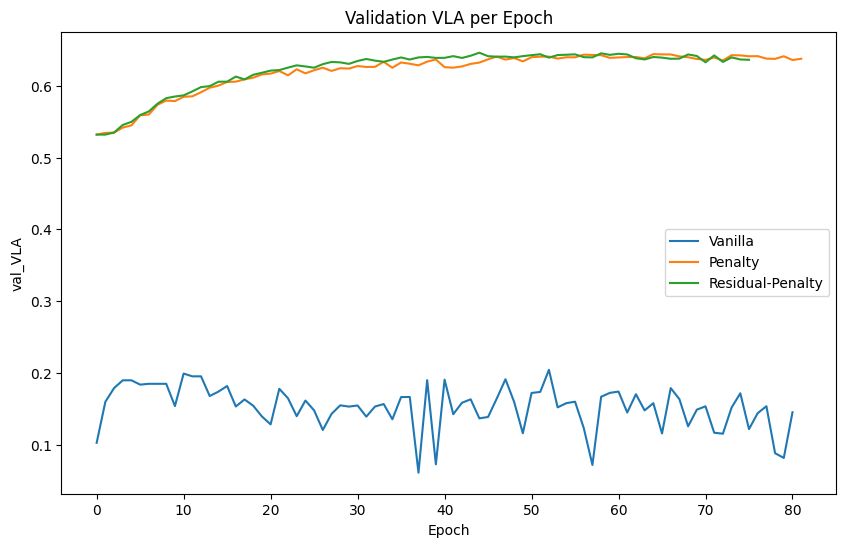

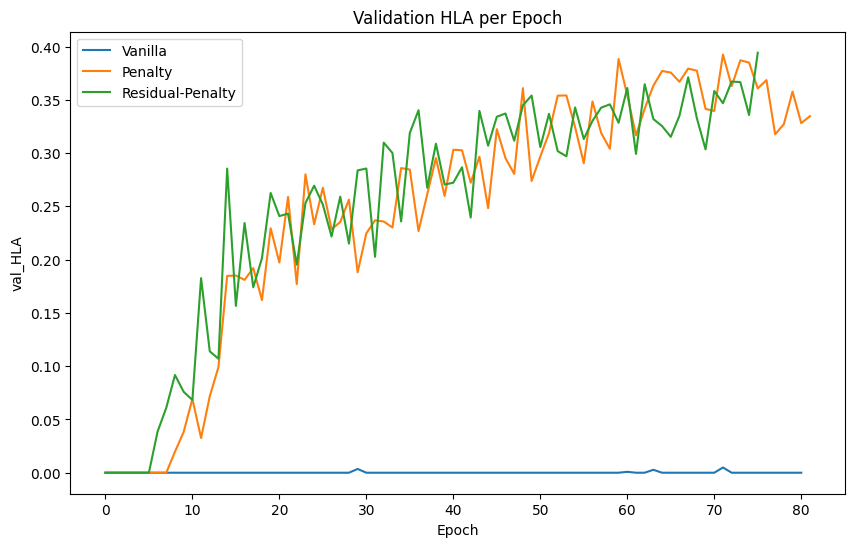

In [ ]:
def plot_metric(logs_dict, metric_key, title):
    plt.figure(figsize=(10,6))
    for name, logs in logs_dict.items():
        plt.plot([l[metric_key] for l in logs], label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric_key)
    plt.title(title)
    plt.legend()
    plt.show()

logs_dict = {
    "Vanilla": logs_vanilla,
    "Penalty": logs_penalty,
    "Residual-Penalty": logs_residual_penalty
}

plot_metric(logs_dict, "val_CLA", "Validation CLA per Epoch")
plot_metric(logs_dict, "val_VLA", "Validation VLA per Epoch")
plot_metric(logs_dict, "val_HLA", "Validation HLA per Epoch")

In [ ]:
summary_data = []
for name, logs in logs_dict.items():
    best_epoch = min(range(len(logs)), key=lambda i: logs[i]['val_loss'])
    best_metrics = logs[best_epoch]
    summary_data.append({
        "Model": name,
        "Best Epoch": best_epoch+1,
        "Val Loss": best_metrics['val_loss'],
        "Val CLA": best_metrics['val_CLA'],
        "Val VLA": best_metrics['val_VLA'],
        "Val HLA": best_metrics['val_HLA']
    })

df_summary = pd.DataFrame(summary_data)
df_summary

,Model,Best Epoch,Val Loss,Val CLA,Val VLA,Val HLA
0,Vanilla,71,1.279367,0.104200,0.153415,0.000000
1,Penalty,72,0.250833,0.878404,0.639628,0.392510
2,Residual-Penalty,66,0.249779,0.878325,0.639398,0.315235


In [ ]:
def evaluate_and_predict(
    models_dict,
    best_paths,
    test_loader,
    criterion,
    vocab_size,
    device,
    idx2char,
    PAD_IDX,
    SOS_IDX,
    EOS_IDX,
    max_len=None
):

    test_results = {}

    for name, model in models_dict.items():
        model.load_state_dict(torch.load(best_paths[name]))
        loss, metrics = validate(
            model,
            test_loader,
            criterion,
            vocab_size,
            device,
            idx2char,
            PAD_IDX,
            SOS_IDX,
            EOS_IDX
        )
        test_results[name] = {"Test Loss": loss, **metrics}

    test_results_df = pd.DataFrame(test_results).T

    # Prediction
    for m in models_dict.values():
        m.eval()

    inputs_list = []
    targets_list = []
    preds_dict = {name: [] for name in models_dict.keys()}

    with torch.no_grad():
        for inputs, targets, input_lengths, target_lengths in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            gold_out = targets[:, 1:]

            for name, model in models_dict.items():
                preds = greedy_decode(
                    model,
                    inputs,
                    input_lengths,
                    max_len or gold_out.size(1),
                    device,
                    SOS_IDX,
                    EOS_IDX,
                    PAD_IDX
                )

                # Aligning lengths
                if preds.size(1) < gold_out.size(1):
                    pad = torch.full(
                        (preds.size(0), gold_out.size(1) - preds.size(1)),
                        PAD_IDX,
                        dtype=preds.dtype,
                        device=device
                    )
                    preds = torch.cat([preds, pad], dim=1)
                else:
                    preds = preds[:, :gold_out.size(1)]

                def decode(seq):
                    return ''.join(
                        idx2char[idx.item()]
                        for idx in seq
                        if idx.item() not in {PAD_IDX, SOS_IDX, EOS_IDX}
                    )

                for i_seq, t_seq, p_seq in zip(inputs, gold_out, preds):
                    if name == list(models_dict.keys())[0]:
                        inputs_list.append(decode(i_seq))
                        targets_list.append(decode(t_seq))
                    preds_dict[name].append(decode(p_seq))

    data = {"input": inputs_list, "target": targets_list}
    for name in models_dict.keys():
        data[f"{name}_pred"] = preds_dict[name]

    predictions_df = pd.DataFrame(data)

    return test_results_df, predictions_df


In [ ]:
models = {
    "Vanilla": model1,
    "Penalty": model2,
    "Residual-Penalty": model3,
}

test_results_df, df_predictions = evaluate_and_predict(
    models,
    best_models,
    test_loader,
    criterion,
    vocab_size,
    device,
    idx2char,
    PAD_IDX,
    SOS_IDX,
    EOS_IDX
)

test_results_df

,Test Loss,CLA,VLA,HLA
Vanilla,1.254390,0.104195,0.151750,0.000000
Penalty,0.250009,0.876994,0.635854,0.332824
Residual-Penalty,0.249130,0.879149,0.642241,0.314005


In [ ]:
df_predictions.head()

,input,target,Vanilla_pred,Penalty_pred,Residual-Penalty_pred
0,Napalalala ang sitwasyon sa tinatawag nating “...,Napalalalâ ang sitwasyon sa tinatawag nating “...,Sa pagkakataon ang mga panahong ito ay may pag...,Napalalala ong sitwasyon sa tanotowog nating “...,Napalilili ang sitwasyon sa tanotiwag nating “...
1,Nagsisimula ang pagtingin sa ganitong mga bita...,Nagsisimula ang pagtingin sa ganitong mga bita...,Sa pagkakataon ang mga panahong ito ay may pag...,Nagsisimula ang pagtangan sa ganitong mga bata...,Nagsisimula ang pagtangan sa ganitong mga bata...
2,BATEK/BATIK AT YUGTO NG BUHAY,BATEK/BATIK AT YUGTO NG BÚHAY,Sa pagkakataon ang mga panahong ito ay may pag...,BaTaK/BaToK aT YoGTe NG BaHaY,BATIK/BATAK AT YAGTA NG BAHIY
3,"Alinsunod kina Katz at Braly, makukuha ang kom...","Alinsunod kina Katz at Braly, makukuha ang kom...",Sa pagkakataon ang mga panahong ito ay may pag...,"Alansanad kuna Kitz at Brily, makikiha ang kam...","Ilansanad kone Katz at Braly, makikiha ang kam..."
4,At dahil dito’y sa anyong pabigkas na lamang m...,At dahil dito’y sa anyong pabigkas na lámang m...,Sa pagkakataon ang mga panahong ito ay may pag...,At dihil dito’y si Inyong pabugkas na liming m...,It dahil dito’y sa inyong pabagkas na lámang m...


# Results: Latent Space Evaluation

### Extracting Latent Vector

In [ ]:
def get_latents(model, loader, device):
    model.eval()
    latents = []
    with torch.no_grad():
        for inputs, _, input_lengths, _ in loader:
            inputs = inputs.to(device)
            src_lengths = torch.tensor(input_lengths, dtype=torch.long).cpu()
            latent = model.encoder(inputs, src_lengths)
            latents.append(latent.cpu().numpy())
    return np.vstack(latents)

In [ ]:
latents_vanilla = get_latents(model1, test_loader, device)
latents_penalty = get_latents(model2, test_loader, device)
latents_residual = get_latents(model3, test_loader, device)

### Clustering

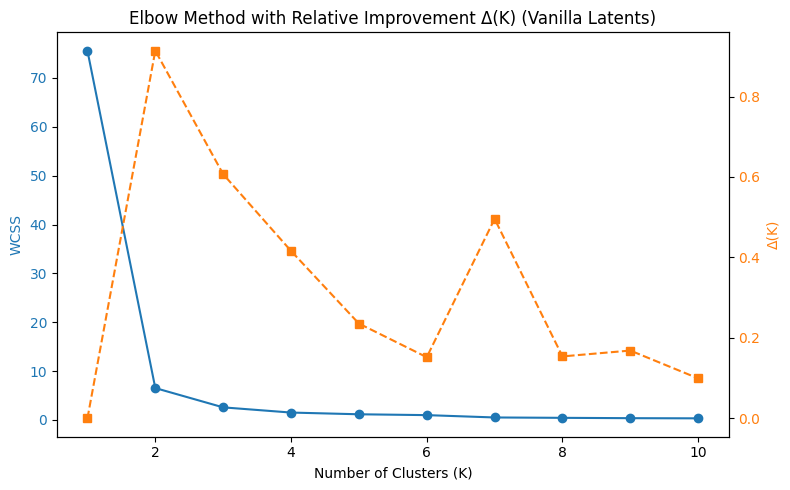

In [ ]:
X = latents_vanilla
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

delta = [0]
for k in range(1, len(wcss)):
    delta_k = (wcss[k-1] - wcss[k]) / wcss[k-1]
    delta.append(delta_k)

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(K_range, wcss, 'o-', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Δ(K)', color=color)
ax2.plot(K_range, delta, 's--', color=color, label='Δ(K)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method with Relative Improvement Δ(K) (Vanilla Latents)')
fig.tight_layout()
plt.show()

In [ ]:
results = pd.DataFrame({
    'K': list(K_range),
    'WCSS': wcss,
    'Delta(K)': delta
})

results

,K,WCSS,Delta(K)
0,1,75.586037,0.000000
1,2,6.508077,0.913898
2,3,2.557515,0.607024
3,4,1.493092,0.416194
4,5,1.141287,0.235622
5,6,0.967840,0.151975
6,7,0.487945,0.495842
7,8,0.412832,0.153936
8,9,0.343267,0.168507
9,10,0.309179,0.099306


Using the elbow method on the vanilla latent space, we choose `k=2`.

In [ ]:
best_k = 2

for latents, name in [
    (latents_vanilla, "Vanilla"),
    (latents_penalty, "Penalty"),
    (latents_residual, "Residual-Penalty")
]:
    kmeans = KMeans(n_clusters=best_k, random_state=42).fit(latents)
    score = silhouette_score(latents, kmeans.labels_)
    print(f"{name}, silhouette={score:.3f}")

Vanilla, silhouette=0.953
Penalty, silhouette=0.977
Residual-Penalty, silhouette=0.999


All three models produce very high silhouette scores at k=2, confirming that two clusters is the most natural grouping in the latent spaces. However, the Penalty and Residual‑Penalty architectures outperform Vanilla, suggesting that architectural constraints improve latent organization.

In [ ]:
models_latents = {
    "Vanilla": latents_vanilla,
    "Penalty": latents_penalty,
    "Residual-Penalty": latents_residual
}

K_range = range(2, 11)
silhouette_results = {}

for name, latents in models_latents.items():
    print(f"\n{name}")
    scores = []
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(latents)
        score = silhouette_score(latents, kmeans.labels_)
        scores.append(score)
        print(f"k={k}, silhouette={score:.3f}")
    silhouette_results[name] = scores


Vanilla
k=2, silhouette=0.953
k=3, silhouette=0.941
k=4, silhouette=0.931
k=5, silhouette=0.728
k=6, silhouette=0.725
k=7, silhouette=0.729
k=8, silhouette=0.738
k=9, silhouette=0.735
k=10, silhouette=0.734

Penalty
k=2, silhouette=0.977
k=3, silhouette=0.962
k=4, silhouette=0.958
k=5, silhouette=0.953
k=6, silhouette=0.953
k=7, silhouette=0.952
k=8, silhouette=0.950
k=9, silhouette=0.953
k=10, silhouette=0.550

Residual-Penalty
k=2, silhouette=0.999
k=3, silhouette=0.996
k=4, silhouette=0.994
k=5, silhouette=0.929
k=6, silhouette=0.928
k=7, silhouette=0.927
k=8, silhouette=0.920
k=9, silhouette=0.920
k=10, silhouette=0.922


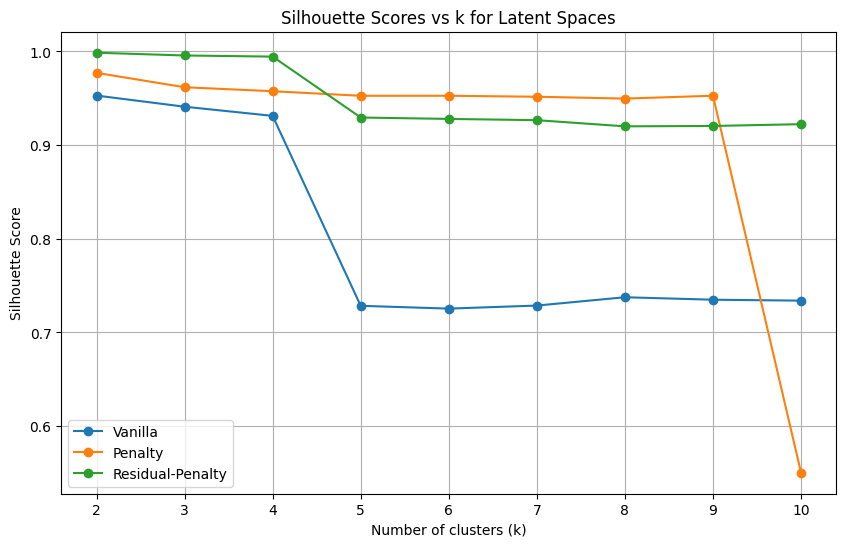

In [ ]:
plt.figure(figsize=(10,6))
for name, scores in silhouette_results.items():
    plt.plot(list(K_range), scores, marker='o', label=name)

plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs k for Latent Spaces")
plt.legend()
plt.grid(True)
plt.show()

Analyzing the clustering performance across different values of $k$, the three models exhibit distinct behaviors. **Vanilla** achieves high silhouette scores for $k=2$ to $k=4$, but its performance drops sharply by $k=5$ and remains consistently lower afterward, indicating that its latent space becomes less separable as cluster count increases. **Penalty** delivers consistently strong scores from $k=2$ to $k=9$, maintaining tight cluster boundaries across a wide range. Its silhouette score collapses only at $k=10$, suggesting that the penalty term enforces robust structure but may over-constrain the representation at higher cluster counts. **Residual-Penalty** achieves the best overall scores, nearly perfect from $k=2$ to $k=4$, and it remains stable and high up to $k=10$, with only a modest decline starting at $k=5$. This indicates that the residual connection helps preserve information while the penalty term sharpens separation.

Overall, Residual-Penalty provides the most flexible and stable latent organization across all cluster sizes, especially for medium to large $k$. Penalty is a strong choice for small to medium $k$ (2–9), while Vanilla performs well only for very coarse clustering (2–4) and degrades quickly afterward.

#### Note:

For a more thorough analysis, please check the notebook file **_Further Latent Space Investigation.ipynb_**, which uses the best-performing models and examines $k$ beyond 10.